In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
import warnings
warnings.filterwarnings('ignore')

# link
# https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

In [2]:
df = pd.read_csv('../cleaned_cpo_price.csv', index_col="Date").dropna()
df

,Price
Date,
3/1/2022,5214.0
4/1/2022,5245.5
5/1/2022,5331.0
6/1/2022,5340.0
7/1/2022,5336.0
...,...
21/12/2022,3901.5
22/12/2022,3886.5
23/12/2022,3890.5


Text(0.5, 0, 'Date')

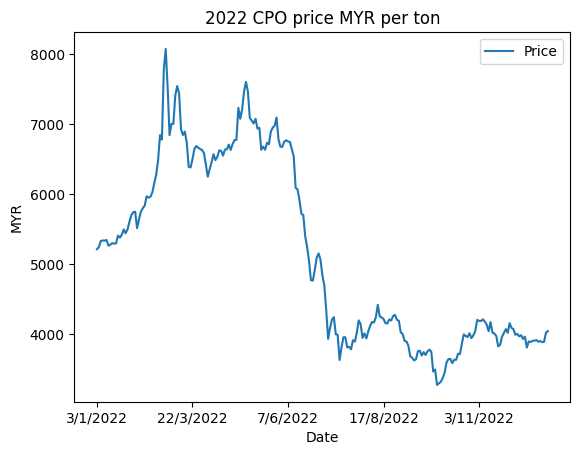

In [3]:
df.plot()
plt.title("2022 CPO price MYR per ton")
plt.ylabel("MYR")
plt.xlabel("Date")

In [4]:
df

,Price
Date,
3/1/2022,5214.0
4/1/2022,5245.5
5/1/2022,5331.0
6/1/2022,5340.0
7/1/2022,5336.0
...,...
21/12/2022,3901.5
22/12/2022,3886.5
23/12/2022,3890.5


# Initial EDA

In [5]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
def adf_test(df):
    """Augmanted Dickey-Fuller test"""
    result = adfuller(df.Price.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

adf_test(df)


ADF Statistic: -0.933500
p-value: 0.776740


Text(0.5, 1.0, 'Autocorrelation Original Series')

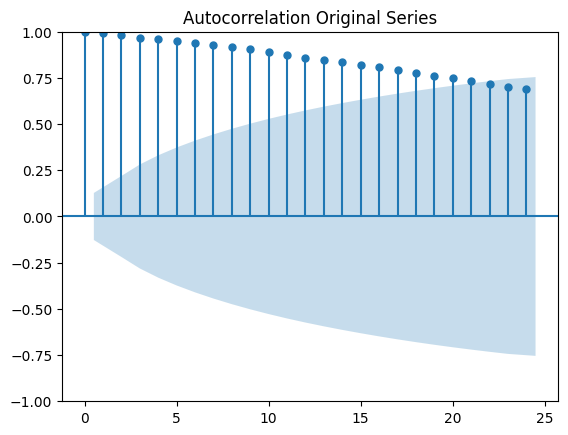

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.Price)
plt.title("Autocorrelation Original Series")

Text(0.5, 1.0, 'Partial Auto Original Series')

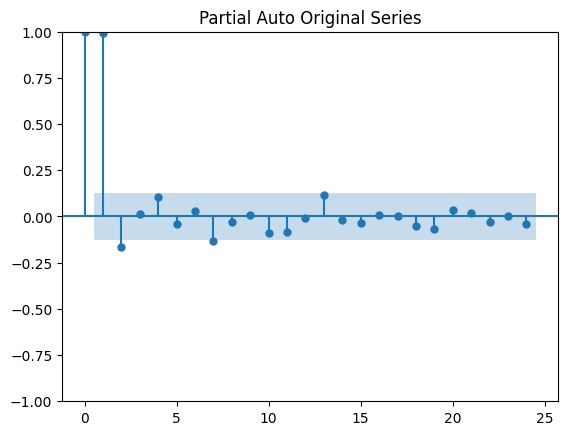

In [7]:
plot_pacf(df.Price)
plt.title("Partial Auto Original Series")

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# split
train = df.iloc[:-47,:]
# 1,1,2 ARIMA Model
model = ARIMA(df.Price, order=(2,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  237
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1532.809
Date:                Thu, 13 Jul 2023   AIC                           3073.617
Time:                        16:28:52   BIC                           3087.490
Sample:                             0   HQIC                          3079.209
                                - 237                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5131.8513   1228.733      4.177      0.000    2723.579    7540.124
ar.L1          1.1768      0.048     24.625      0.000       1.083       1.271
ar.L2         -0.1871      0.048     -3.933      0.0

In [9]:
pred = model_fit.predict(start=237+1, end=237+12)
pred

238    4075.424994
239    4088.901838
240    4102.144862
241    4115.207999
242    4128.103191
243    4140.834397
244    4153.404045
245    4165.814250
246    4178.067046
247    4190.164432
248    4202.108380
249    4213.900837
Name: predicted_mean, dtype: float64

<Axes: >

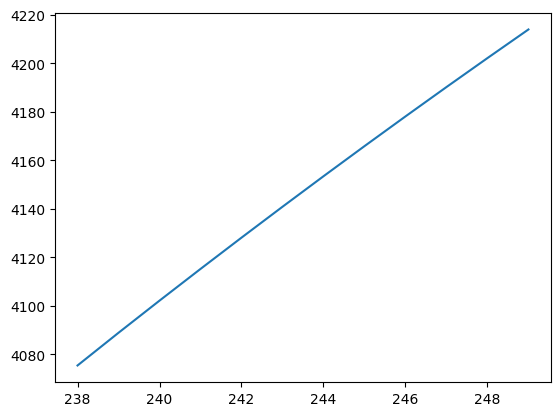

In [10]:
pred.plot()

# one step

In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    test_ = df_cp.iloc[size_:,:]
    train_ = df_cp.iloc[:size_,:]

    # 1,0,0 AR Model
    model = ARIMA(train_.Price, order=(1,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    err = np.sqrt(mean_squared_error(test_, pred)) #rmse
    return err
    
one_step_ahead(df, .8)

def loop_pct():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct()

,pct,res
0,0.80,231.888307
1,0.85,437.604093
2,0.90,203.196131
3,0.95,139.406055


In [12]:
# mape
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
def one_step_ahead_mape(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    test_ = df_cp.iloc[size_:,:]
    train_ = df_cp.iloc[:size_,:]

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Price, order=(1,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    err = mean_absolute_percentage_error(test_, pred) 
    return err
    
one_step_ahead_mape(df, .8)

def loop_pct_mape():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead_mape(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_mape()

,pct,res
0,0.80,0.049979
1,0.85,0.100443
2,0.90,0.044576
3,0.95,0.034132


In [13]:
# pct change measurement

from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead_chg(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    test_ = df_cp.iloc[size_:,:]
    train_ = df_cp.iloc[:size_,:]
    pct_change_test_ = 100 * test_.pct_change().dropna()

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Price, order=(1,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    pred_pct_change = 100 * pred.pct_change().dropna()
    err = np.sqrt(mean_squared_error(pct_change_test_, pred_pct_change)) #rmse
    return err
    
one_step_ahead_chg(df, .8)

def loop_pct_chg():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead_chg(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_chg()

,pct,res
0,0.80,1.891590
1,0.85,1.841219
2,0.90,1.615149
3,0.95,1.178285


In [14]:
# RMSE within-sample & out-sample
from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead_train(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    test_ = df_cp.iloc[size_:,:]



    # pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    # err = np.sqrt(mean_squared_error(test_, pred)) #rmse

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Price, order=(1,0,0))
    model_fit = model.fit()
    # pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    # err = np.sqrt(mean_squared_error(test_, pred))
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    err = np.sqrt(mean_squared_error(test_, pred))

    pred_t = model_fit.predict(start= 0, end = len(train_)-1)
    err_t = np.sqrt(mean_squared_error(train_, pred_t))

    # return pd.concat([err_t,err], axis= 1)
    return (err_t, err)
    
one_step_ahead_train(df, .8)

def loop_pct_train():
    dict = {'pct':[], '(train, test)':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['(train, test)'].append(one_step_ahead_train(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_train()

,pct,"(train, test)"
0,0.80,"(172.44229013046163, 231.8883073593601)"
1,0.85,"(168.30729945286689, 437.6040926744367)"
2,0.90,"(164.62896944498527, 203.19613100813027)"
3,0.95,"(160.75101523204722, 139.40605524583268)"


### Plotting 

,Train
Date,
3/1/2022,5214.0
4/1/2022,5245.5
5/1/2022,5331.0
6/1/2022,5340.0
7/1/2022,5336.0
...,...
7/10/2022,3646.0
11/10/2022,3586.0
12/10/2022,3635.5


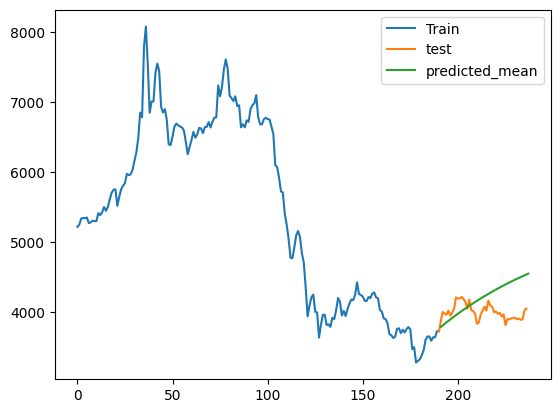

In [15]:
# ploting results
def plot_res(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    train_.rename(columns={'Price': 'Train'}, inplace=True)
    test_ = df_cp.iloc[size_:,:]
    test_.rename(columns={'Price': 'test'}, inplace=True)
    # pct_change_test_ = 100 * test_.pct_change().dropna()

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Train, order=(2,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))

    df_plot = pd.concat([train_, test_], axis= 1)
    df_plot.reset_index(inplace=True, drop=True)
    df_plot = pd.concat([df_plot, pred], axis= 1)
    # df_plot.rename(columns={'Price': 'Train', 'Price': 'Test', 'predicted_mean': 'Forecast'}, inplace=True)
    df_plot.plot()
    return train_


    
plot_res(df, .8)

<Axes: >

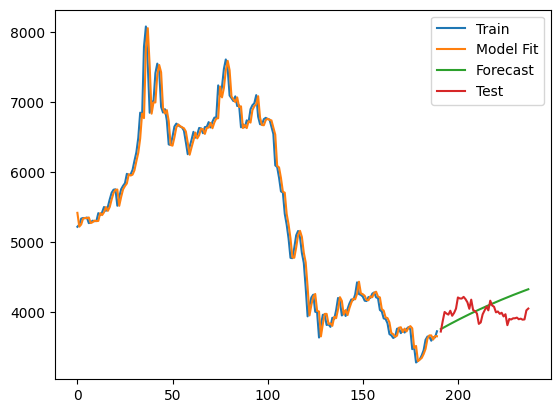

In [16]:
def plot_res_train(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    train_.rename(columns={'Price': 'Train'}, inplace=True)
    test_ = df_cp.iloc[size_:,:]
    test_.rename(columns={'Price': 'test'}, inplace=True)
    # pct_change_test_ = 100 * test_.pct_change().dropna()

    # MA 2
    model = ARIMA(train_.Train, order=(1,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    pred_t = model_fit.predict(start= 0, end = len(train_)-1)

    df_plot = pd.concat([train_, pred_t], axis= 1)
    df_plot.reset_index(inplace=True, drop=True)
    df_plot = pd.concat([df_plot, pred], axis= 1)
    test_.set_index(keys = pred.index, inplace = True)
    df_plot = pd.concat([df_plot, test_], axis= 1)
    df_plot.columns = ['Train', 'Model Fit', 'Forecast', 'Test']
    

    return df_plot.plot()

plot_res_train(df, .8)